In [70]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

In [71]:
# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')


In [72]:
# Define parameters
random_state = 42
test_size = 0.2
epochs = 50 # Increased epochs for potentially better convergence
batch_size = 32
patience = 10 # Early stopping patience

In [73]:
# Load dataset
try:
    df = pd.read_csv('breast_cancer.csv')
    print("Dataset loaded successfully.")
    display(df.head())
except FileNotFoundError:
    print("Error: breast_cancer.csv not found. Please make sure the file is in the correct directory.")
    # Handle error appropriately, e.g., exit or try a different path
    exit()


Dataset loaded successfully.


,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [74]:
#clean the dataset
if 'Sample code number' in df.columns:
    df.drop(columns=['Sample code number'], inplace=True)
    print("'Sample code number' column dropped.")

#check for missing values
df.isnull().sum()

'Sample code number' column dropped.


Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [77]:
# Map Class values to binary (0 = benign, 1 = malignant)
if 'Class' in df.columns:
    df['Class'] = df['Class'].map({2: 0, 4: 1})
    print("\n'Class' column mapped to 0 (benign) and 1 (malignant).")
    display(df['Class'].value_counts())
else:
    print("Error: 'Class' column not found in the dataset.")
    exit()





'Class' column mapped to 0 (benign) and 1 (malignant).


Class
0    444
1    239
Name: count, dtype: int64

In [78]:
# Split features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']
feature_names = X.columns
print(f"\nFeatures (X shape): {X.shape}")
print(f"Target (y shape): {y.shape}")


Features (X shape): (683, 9)
Target (y shape): (683,)


In [79]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
print(f"\nData split: {len(X_train)} training samples, {len(X_test)} testing samples.")



Data split: 546 training samples, 137 testing samples.


In [80]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
# Save the scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to models/scaler.pkl


In [82]:
def build_deep_learning_model(input_dim):
    """Builds the Keras Sequential deep learning model."""
    model = Sequential([
        Input(shape=(input_dim,)), # Use Input layer for explicit shape definition
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid') # Output layer for binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [83]:
def build_logistic_regression_model(random_state=42):
    """Builds the Logistic Regression model."""
    return LogisticRegression(
        class_weight='balanced', # Handles class imbalance
        max_iter=1000, # Increased iterations for convergence
        random_state=random_state,
        C=1.0 # Regularization strength
    )

In [84]:
def build_random_forest_model(random_state=42):
    """Builds the Random Forest model."""
    return RandomForestClassifier(
        n_estimators=100, # Number of trees
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced', # Handles class imbalance
        random_state=random_state
    )

In [85]:

def plot_training_history(history, model_name):
    """Plots the training and validation accuracy and loss."""
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # Save the plot
    plot_path = f'models/{model_name.replace(" ", "_").lower()}_training_history.png'
    plt.savefig(plot_path)
    print(f"Training history plot saved to {plot_path}")
    plt.show()

In [86]:

def plot_model_performance(results):
    """Plots the ROC AUC scores for different models."""
    if not results:
        print("No results to plot.")
        return

    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    scores = list(results.values())

    if not models: # Check if models list is empty
        print("No models found in results to plot.")
        return

    best_model = max(results, key=results.get)
    best_score = results[best_model]

    # Create bars with different colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bars = plt.bar(models, scores, color=colors[:len(models)])

    # Add chart elements
    plt.ylim(min(scores) * 0.95 if scores else 0, max(scores) * 1.05 if scores else 1) # Dynamic ylim
    plt.ylabel('ROC AUC Score')
    plt.xlabel('Models')
    plt.title('Model Performance Comparison (ROC AUC)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Highlight the best model
    try:
        best_index = models.index(best_model)
        bars[best_index].set_color('#d62728') # Highlight color
        bars[best_index].set_edgecolor('black')
        bars[best_index].set_linewidth(1.5)
        plt.text(best_index, best_score + 0.01, f'Best: {best_score:.4f}', ha='center', fontweight='bold')
    except ValueError:
        print(f"Warning: Best model '{best_model}' not found in results.")

    # Add score labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # Add text labels

    plt.tight_layout()
    # Save the plot
    plot_path = 'models/model_comparison.png'
    plt.savefig(plot_path)
    print(f"Model comparison plot saved to {plot_path}")
    plt.show()


In [87]:

def plot_feature_importance(model, model_name, feature_names):
    """Plots feature importances for Logistic Regression or Random Forest."""
    importances = None
    if hasattr(model, 'feature_importances_'): # Random Forest
        importances = model.feature_importances_
        title = 'Random Forest Feature Importance'
        color = 'lightblue'
    elif hasattr(model, 'coef_'): # Logistic Regression
        importances = np.abs(model.coef_[0]) # Use absolute values for importance magnitude
        title = 'Logistic Regression Feature Importance (Absolute Coef)'
        color = 'salmon'
    else:
        print(f"Feature importance plotting not supported for {model_name}.")
        return

    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], color=color, align='center')
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot
    plot_path = f'models/{model_name.replace(" ", "_").lower()}_feature_importance.png'
    plt.savefig(plot_path)
    print(f"Feature importance plot saved to {plot_path}")
    plt.show()


In [88]:
def plot_confusion_matrix_func(model, model_name, X_test, y_test):
    """Plots the confusion matrix for a given model."""
    # Get predictions (handle different predict methods)
    if hasattr(model, 'predict_proba') and not isinstance(model, (LogisticRegression, RandomForestClassifier)): # DL model gives probabilities
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten() # Convert probabilities to binary predictions
    else: # Sklearn models
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    # Save the plot
    plot_path = f'models/{model_name.replace(" ", "_").lower()}_confusion_matrix.png'
    plt.savefig(plot_path)
    print(f"Confusion matrix plot saved to {plot_path}")
    plt.show()

In [89]:
# 6. Model Training and Evaluation

# Initialize results dictionary
results = {}

In [90]:
# Build and train Logistic Regression model
lr_model = build_logistic_regression_model(random_state=random_state)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")


Logistic Regression model trained.


In [91]:
# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1] # Probabilities for ROC AUC


In [92]:
print("\nLogistic Regression Evaluation")
print(classification_report(y_test, y_pred_lr, target_names=['Benign (0)', 'Malignant (1)']))
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
results['Logistic Regression'] = roc_auc_lr
print(f"ROC Score: {roc_auc_lr:.4f}")



Logistic Regression Evaluation
               precision    recall  f1-score   support

   Benign (0)       0.99      0.96      0.97        89
Malignant (1)       0.92      0.98      0.95        48

     accuracy                           0.96       137
    macro avg       0.95      0.97      0.96       137
 weighted avg       0.96      0.96      0.96       137

ROC Score: 0.9918


Feature importance plot saved to models/logistic_regression_feature_importance.png


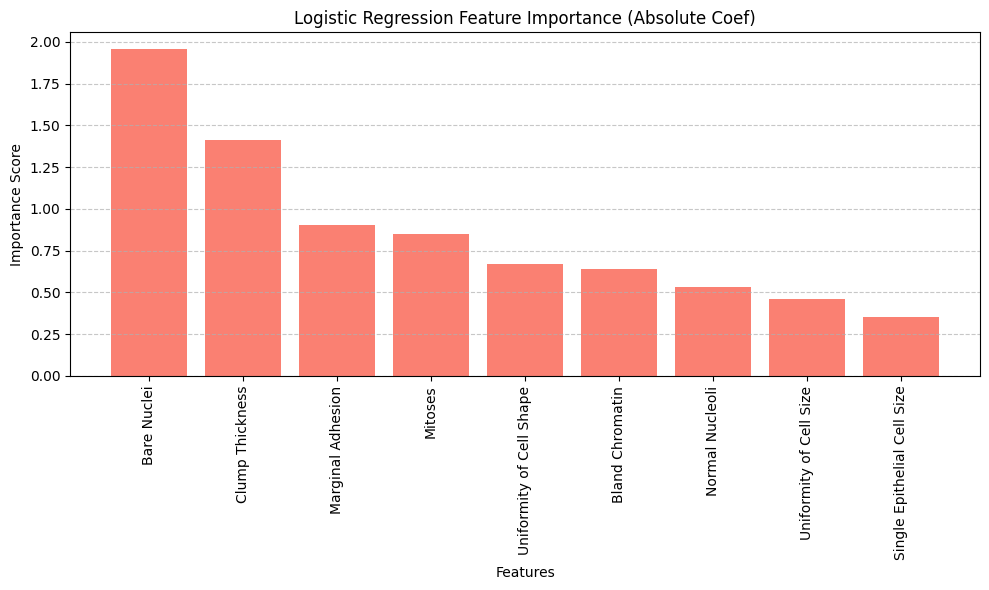

In [93]:
# Plot Feature Importance for Logistic Regression
plot_feature_importance(lr_model, 'Logistic Regression', feature_names)


In [95]:
# Save the Logistic Regression model
lr_model_path = 'models/logistic_regression_model.pkl'
joblib.dump(lr_model, lr_model_path)
print(f"Logistic Regression model saved to {lr_model_path}")


Logistic Regression model saved to models/logistic_regression_model.pkl


In [96]:
# 6.2 Random Forest

# Build and train Random Forest model
rf_model = build_random_forest_model(random_state=random_state)
rf_model.fit(X_train_scaled, y_train)
print("\nRandom Forest model trained.")


Random Forest model trained.


In [97]:
# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1] # Probabilities for ROC AUC


In [98]:
print("Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf, target_names=['Benign (0)', 'Malignant (1)']))
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
results['Random Forest'] = roc_auc_rf
print(f"ROC Score: {roc_auc_rf:.4f}")

Random Forest Evaluation
               precision    recall  f1-score   support

   Benign (0)       1.00      0.96      0.98        89
Malignant (1)       0.92      1.00      0.96        48

     accuracy                           0.97       137
    macro avg       0.96      0.98      0.97       137
 weighted avg       0.97      0.97      0.97       137

ROC Score: 0.9864


Feature importance plot saved to models/random_forest_feature_importance.png


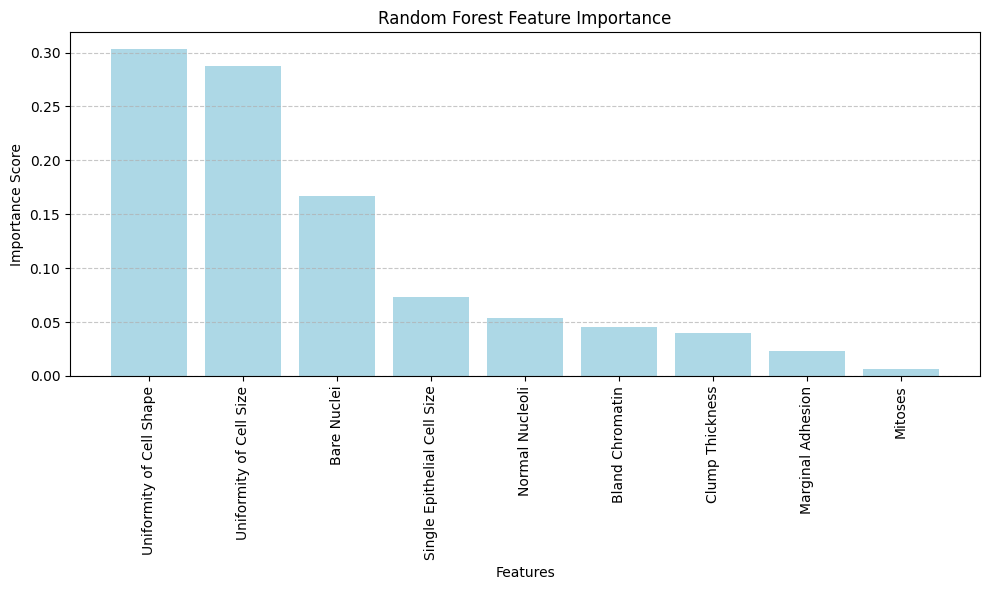

In [99]:
# Plot Feature Importance for Random Forest
plot_feature_importance(rf_model, 'Random Forest', feature_names)

In [101]:
# Save the Random Forest model
rf_model_path = 'models/random_forest_model.pkl'
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")


Random Forest model saved to models/random_forest_model.pkl


In [102]:
# 6.3 Deep Learning Model

# Define the input dimension for the DL model
input_dim = X_train_scaled.shape[1]
print(f"\nInput dimension for Deep Learning model: {input_dim}")



Input dimension for Deep Learning model: 9


In [103]:
# Build the Deep Learning model
dl_model = build_deep_learning_model(input_dim)
print("\nDeep Learning model built.")
dl_model.summary() # Print model summary



Deep Learning model built.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 192 (768.00 B)

In [104]:
# Visualize the model architecture (requires pydot and graphviz)
model_architecture_path = 'models/deep_learning_architecture.png'
try:
    plot_model(dl_model, to_file=model_architecture_path, show_shapes=True, show_layer_names=True)
    print(f"Model architecture plot saved to {model_architecture_path}")
    # Display the image in the notebook
    display(Image(filename=model_architecture_path))
except ImportError as e:
    print(f"Could not plot model architecture: {e}. Please install pydot and graphviz.")
except Exception as e:
    print(f"An error occurred while plotting model architecture: {e}")


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Model architecture plot saved to models/deep_learning_architecture.png
An error occurred while plotting model architecture: [Errno 2] No such file or directory: 'models/deep_learning_architecture.png'


In [105]:
# Define callbacks for the Deep Learning model
dl_model_path = 'models/deep_learning_model.keras'
callbacks = [
    ModelCheckpoint(
        filepath=dl_model_path,
        monitor='val_loss', # Monitor validation loss
        save_best_only=True, # Save only the best model
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=patience, # Stop if no improvement after 'patience' epochs
        restore_best_weights=True, # Restore weights from the best epoch
        verbose=1
    )
]

In [106]:
# Calculate class weights (optional, but helpful for imbalanced datasets)
# Weight for class 0: total_samples / (n_classes * count_class_0)
# Weight for class 1: total_samples / (n_classes * count_class_1)
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0) if neg > 0 else 0
weight_for_1 = (1 / pos) * (total / 2.0) if pos > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"\nCalculated Class Weights: {class_weight}")



Calculated Class Weights: {0: np.float64(0.7690140845070423), 1: np.float64(1.4293193717277488)}


In [107]:
# Train the Deep Learning model
print("\nStarting Deep Learning model training...")
history = dl_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2, # Use part of training data for validation during training
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weight, # Use calculated class weights
    verbose=1 # Show progress
)
print("\nDeep Learning model training finished.")



Starting Deep Learning model training...
Epoch 1/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - accuracy: 0.4688 - loss: 1.2321
Epoch 1: val_loss improved from inf to 0.49106, saving model to models/deep_learning_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6302 - loss: 0.8005 - val_accuracy: 0.9727 - val_loss: 0.4911
Epoch 2/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9062 - loss: 0.4116
Epoch 2: val_loss improved from 0.49106 to 0.36199, saving model to models/deep_learning_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8984 - loss: 0.3045 - val_accuracy: 0.9727 - val_loss: 0.3620
Epoch 3/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1022
Epoch 3: val_loss improved from 0.36199 to 0.28558, saving model to models/deep_learning_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.1611 - val_accuracy: 0.9727 - val_loss: 0.2856
Epoch 4/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accurac

In [108]:
# Load the best saved model (due to ModelCheckpoint)
print(f"Loading best Deep Learning model from {dl_model_path}")
best_dl_model = load_model(dl_model_path)


Loading best Deep Learning model from models/deep_learning_model.keras


Training history plot saved to models/deep_learning_model_training_history.png


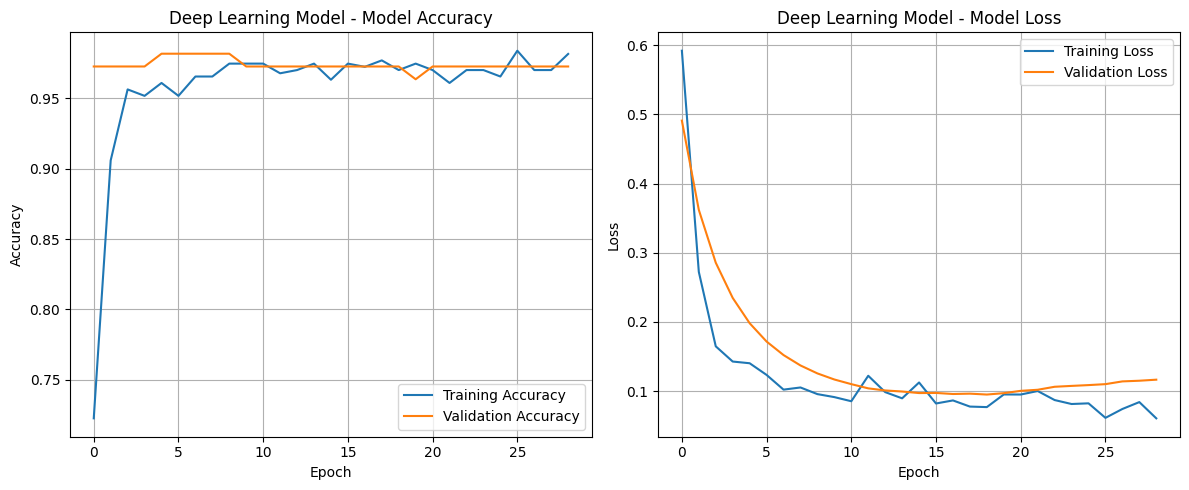

In [109]:
# Plot Training History for Deep Learning Model
plot_training_history(history, 'Deep Learning Model')


In [110]:
# Evaluate the best Deep Learning model
print("\nDeep Learning Model Evaluation (Best Model)")
loss_dl, accuracy_dl = best_dl_model.evaluate(X_test_scaled, y_test, verbose=0)
y_prob_dl = best_dl_model.predict(X_test_scaled).flatten() # Probabilities
y_pred_dl = (y_prob_dl > 0.5).astype(int) # Binary predictions



Deep Learning Model Evaluation (Best Model)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [113]:
print(f"Test Loss: {loss_dl:.4f}")
print(f"Test Accuracy: {accuracy_dl:.4f}")
print(classification_report(y_test, y_pred_dl, target_names=['Benign (0)', 'Malignant (1)']))
roc_auc_dl = roc_auc_score(y_test, y_prob_dl)
results['Deep Learning'] = roc_auc_dl
print(f"ROC Score: {roc_auc_dl:.4f}")



Test Loss: 0.1133
Test Accuracy: 0.9562
               precision    recall  f1-score   support

   Benign (0)       0.98      0.96      0.97        89
Malignant (1)       0.92      0.96      0.94        48

     accuracy                           0.96       137
    macro avg       0.95      0.96      0.95       137
 weighted avg       0.96      0.96      0.96       137

ROC Score: 0.9932


In [115]:
# 7. Model Comparison

# Print final results
print("\n--- Final Model ROC Scores ---")
for name, score in results.items():
    print(f"{name}: {score:.4f}")




--- Final Model ROC AUC Scores ---
Logistic Regression: 0.9918
Random Forest: 0.9864
Deep Learning: 0.9932


Model comparison plot saved to models/model_comparison.png


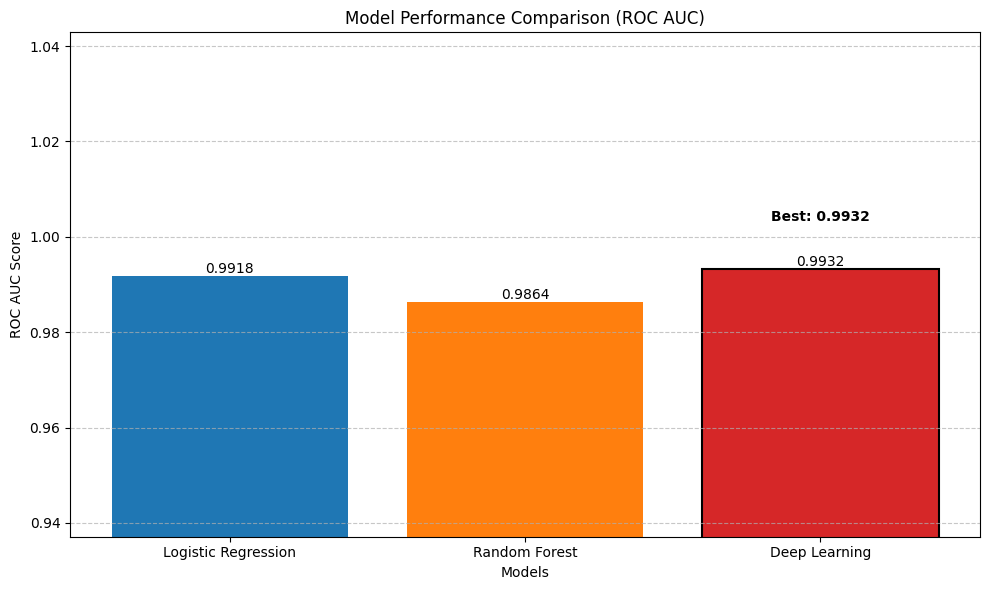

In [116]:

# Plot model performance comparison
plot_model_performance(results)


Conclusion

This analysis compared three different models (Logistic Regression, Random Forest, and a Deep Learning Neural Network)
for classifying breast cancer tumors as benign (0) or malignant (1) based on the Wisconsin Diagnostic Breast Cancer dataset.

Key Findings:
- Overall Performance: All three models demonstrated very high performance, achieving excellent accuracy and ROC scores on the test set.
- Best ROC: The Deep Learning model achieved the highest ROC score (0.9932), indicating slightly better overall discriminatory power. Logistic Regression followed closely (0.9918).
- Random Forest Performance: Achieved strong ROC (0.9864) and perfect recall (1.00) for the malignant class, minimizing false negatives. Precision for malignant was 0.92.
- Logistic Regression Performance: Provided a robust baseline with high precision (0.92 malignant, 0.99 benign) and recall (0.98 malignant, 0.96 benign).
- Deep Learning Training: Training history plots showed good convergence and generalization without significant overfitting.
- Feature Importance: 'Bare Nuclei', 'Uniformity of Cell Size/Shape', 'Clump Thickness', 'Marginal Adhesion', and 'Mitoses' were highlighted as important features by LR and RF models.

Summary:
The Deep Learning model slightly leads in ROC, but Random Forest's perfect malignant recall is clinically significant.
Logistic Regression offers good performance and interpretability. The best model depends on the specific priorities.
All models and the scaler are saved in the 'models/' directory.